Aquest Notebook estarà dedicat a fer un model que pugui fer la predicció sobre si un Pokémon és realment legendari. Ens basarem en les estadístiques d'aquests i altres paràmetres per veure si els Pokémon legendaris ho haurien de ser per estadístiques i si hi hagués altres Pokémon que no ho fossin si poguessin entrar en aquesta categoria.

In [96]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import sklearn
import os

In [97]:
df = pd.read_csv('pokemon.csv')
df.shape

(801, 41)

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   abilities          801 non-null    object 
 1   against_bug        801 non-null    float64
 2   against_dark       801 non-null    float64
 3   against_dragon     801 non-null    float64
 4   against_electric   801 non-null    float64
 5   against_fairy      801 non-null    float64
 6   against_fight      801 non-null    float64
 7   against_fire       801 non-null    float64
 8   against_flying     801 non-null    float64
 9   against_ghost      801 non-null    float64
 10  against_grass      801 non-null    float64
 11  against_ground     801 non-null    float64
 12  against_ice        801 non-null    float64
 13  against_normal     801 non-null    float64
 14  against_poison     801 non-null    float64
 15  against_psychic    801 non-null    float64
 16  against_rock       801 non

In [99]:
df.describe()

,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,...,height_m,hp,percentage_male,pokedex_number,sp_attack,sp_defense,speed,weight_kg,generation,is_legendary
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,...,781.000000,801.000000,703.000000,801.000000,801.000000,801.000000,801.000000,781.000000,801.000000,801.000000
mean,0.996255,1.057116,0.968789,1.073970,1.068976,1.065543,1.135456,1.192884,0.985019,1.034020,...,1.163892,68.958801,55.155761,401.000000,71.305868,70.911361,66.334582,61.378105,3.690387,0.087391
std,0.597248,0.438142,0.353058,0.654962,0.522167,0.717251,0.691853,0.604488,0.558256,0.788896,...,1.080326,26.576015,20.261623,231.373075,32.353826,27.942501,28.907662,109.354766,1.930420,0.282583
min,0.250000,0.250000,0.000000,0.000000,0.250000,0.000000,0.250000,0.250000,0.000000,0.250000,...,0.100000,1.000000,0.000000,1.000000,10.000000,20.000000,5.000000,0.100000,1.000000,0.000000
25%,0.500000,1.000000,1.000000,0.500000,1.000000,0.500000,0.500000,1.000000,1.000000,0.500000,...,0.600000,50.000000,50.000000,201.000000,45.000000,50.000000,45.000000,9.000000,2.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,65.000000,50.000000,401.000000,65.000000,66.000000,65.000000,27.300000,4.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,...,1.500000,80.000000,50.000000,601.000000,91.000000,90.000000,85.000000,64.800000,5.000000,0.000000
max,4.000000,4.000000,2.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,14.500000,255.000000,100.000000,801.000000,194.000000,230.000000,180.000000,999.900000,7.000000,1.000000


# Gestió de NaNs i Possibles Mapejats

## NaNs

Primer de tot veurem quines columnes hi ha amb NaNs i com ho gestionarem:

In [100]:
col_num = list(df.select_dtypes(exclude=['object']).columns)
col_obj = list(df.select_dtypes(include=['object']).columns)
col_nans = df.columns[df.isnull().any()]

print("Columnes numèriques:", len(col_num))
print("Columnes objecte:", len(col_obj))
print("Columnes amb NaNs:", len(col_nans))

Columnes numèriques: 34
Columnes objecte: 7
Columnes amb NaNs: 4


In [101]:
df[col_nans].head()

,height_m,percentage_male,type2,weight_kg
0,0.7,88.1,poison,6.9
1,1.0,88.1,poison,13.0
2,2.0,88.1,poison,100.0
3,0.6,88.1,NaN,8.5
4,1.1,88.1,NaN,19.0


In [102]:
print("Nombre de valors nuls per columna:")
df[col_nans].isnull().sum()

Nombre de valors nuls per columna:


height_m            20
percentage_male     98
type2              384
weight_kg           20
dtype: int64

El major nombre de NaNs està a type2. Explorarem amb dades reals per què hi ha tantes NaNs. Posem l'exemple més conegut de tots "Pikachu", sabem que és de tipus Elèctric i no te cap tipus secundari.

In [103]:
df[df.name == 'Pikachu'][["name","type1","type2"]]

,name,type1,type2
24,Pikachu,electric,NaN


Veiem que està el NaN a type2, que passarà si busquem un Pokémon amb un tipus secundari? Per exemple, Charizard?

In [104]:
df[df.name == 'Charizard'][["name","type1","type2"]]

,name,type1,type2
5,Charizard,fire,flying


Sembla que el NaN a type2 és pels Pokémon que no tenen tipus secundari. Per arreglar això, mapejarem les nans a tipus: None.

In [105]:
df.type2.fillna("None", inplace=True)
df[df.name == 'Pikachu'][["name","type1","type2"]]

,name,type1,type2
24,Pikachu,electric,None


Ara, Pikachu tindrà els dos tipus bén marcats.

## Columnes Objecte

Seguidament, veurem si les columnes objecte estan ben distribuides.

In [106]:
df[col_obj].head()

,abilities,capture_rate,classfication,japanese_name,name,type1,type2
0,"['Overgrow', 'Chlorophyll']",45,Seed Pokémon,Fushigidaneフシギダネ,Bulbasaur,grass,poison
1,"['Overgrow', 'Chlorophyll']",45,Seed Pokémon,Fushigisouフシギソウ,Ivysaur,grass,poison
2,"['Overgrow', 'Chlorophyll']",45,Seed Pokémon,Fushigibanaフシギバナ,Venusaur,grass,poison
3,"['Blaze', 'Solar Power']",45,Lizard Pokémon,Hitokageヒトカゲ,Charmander,fire,None
4,"['Blaze', 'Solar Power']",45,Flame Pokémon,Lizardoリザード,Charmeleon,fire,None


De les 7 que hem vist abans, tenim capture_rate que sembla que hauría de ser numèrica però està aquí. 

### Capture rate

In [107]:
print(df['capture_rate'].unique())

['45' '255' '120' '127' '90' '190' '75' '235' '150' '25' '170' '50' '200'
 '100' '180' '60' '225' '30' '35' '3' '65' '70' '125' '205' '155' '145'
 '130' '140' '15' '220' '160' '80' '55' '30 (Meteorite)255 (Core)']


Veiem que hi ha un valor extrany "30 (Meteorite)255 (Core)". Mirem de quin Pokémon es tracta:

In [108]:
df[df.capture_rate == '30 (Meteorite)255 (Core)'][["name"]]

,name
773,Minior


Fent una investigació a diferentes pàgines, arribem a la conclusió que varia entre 30 i 255 el seu capture_rate. Per tant, seguirem el que marca una de les wikis més importants de Pokémon i ho mapejarem a 30 ja que sol ser el més comú.

Font: "https://bulbapedia.bulbagarden.net/wiki/Minior_(Pok%C3%A9mon)"

In [109]:
df.capture_rate = df.capture_rate.replace('30 (Meteorite)255 (Core)', 30)
df.capture_rate = df.capture_rate.astype(int)

### Name i Japanese Name

Seguidament avaluarem les columnes que són identificatives i que no ens serviran a l'hora de fer l'estudi (En el primer intent he fet això just al moment de començar a valorar les columnes objecte i no podia trobar el nom del Pokémon amb l'error):

    - Japanese_name: El nom en Japonès no ens serveix.
    - Name: El nom que utilitza la majoria de la població tampoc.

De moment aquestes dues principalment no ens serviran a l'hora de fer l'estudi, per tant seran les primeres en sortir del dataset.

In [110]:
col_obj.remove("name")
col_obj.remove("japanese_name")

### Abilities

Primer de tot valorarem els valors únics a la columna per entendre quants valors diferents hi ha, la freqüència...

In [111]:
def len_abilities(l):
    if l[0] != '[':
        return 1
    else:
        l = l.replace("'", "").replace(" ", "").strip('[]').split(',')
        return len(l)    

In [112]:
# Aplica la función len_abilities a la columna 'abilities' para obtener el número de habilidades
df['num_abilities'] = df['abilities'].apply(len_abilities)

# Explode la columna 'abilities' para obtener filas separadas para cada habilidad
df_exploded = df.explode('abilities')

# Gráfico de barras para la frecuencia de cada habilidad
abilities_freq = df_exploded['abilities'].value_counts().reset_index(name='count')

fig = px.bar(abilities_freq, x='abilities', y='count', title='Frecuencia de Cada Habilidad')
fig.update_xaxes(title_text='Habilidad')
fig.update_yaxes(title_text='Frecuencia')
fig.show()

Podem observar que la habilitat més comú és Levitate amb 29 Pokémon diferents que la tenen, però volem veure els legendaris si tenen alguna en comú o són diferents:

In [113]:
legendary_with_ability = df[df['is_legendary'] == 1]['abilities'].value_counts().reset_index(name='count')

fig = px.pie(legendary_with_ability, values='count', names='abilities', title='Proporción de Pokémon Legendarios con una Habilidad Específica')
fig.show()

Observem que hi ha habilitats que sí estan en comú en alguns Pokémon legendaris, abans de decidir si la treiem o no, veurem el nombre d'habilitats que pot tenir un Pokémon.

In [114]:
df['num_abilities'] = df['abilities'].apply(len_abilities)

fig_all = px.histogram(df, x='num_abilities', title='Distribución de la Cantidad de Habilidades para Todos los Pokémon')
fig_all.update_xaxes(title_text='Número de Habilidades')
fig_all.update_yaxes(title_text='Frecuencia')
fig_all.show()

I també ho farem pels legendaris:

In [115]:
df_legendary = df[df['is_legendary'] == 1]
df_legendary['num_abilities'] = df_legendary['abilities'].apply(len_abilities)

fig_legendary = px.histogram(df_legendary, x='num_abilities', title='Distribución de la Cantidad de Habilidades para Pokémon Legendarios')
fig_legendary.update_xaxes(title_text='Número de Habilidades')
fig_legendary.update_yaxes(title_text='Frecuencia')
fig_legendary.show()

C:\Users\victo\AppData\Local\Temp\ipykernel_26940\3520446066.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



He tingut un petit error on no he pogut separar les habilitats de forma individual per imprimir  les més comuns, però podem observar que hi ha masses valors únics i molts Pokémon comparteixen habilitats siguin o no legendaris, per tant no és del tot clar que ens serveixi.

In [116]:
col_obj.remove("abilities")

### Classification

Seguint amb la classificació, és el nom que se li dona a cada Pokémon, podem treure-la ja que sol ser idèntica a cada linia evolutiva i no és gaire retllevant

In [117]:
col_obj.remove("classfication")

### Type 1 i Type 2

Aquestes columnes seran interessants, ja que el tipus del Pokémon és una de les característiques principals a l'hora de fer càlculs d'estadística... Per tant serà  interessant veure les correlacions entre Pokémon legendaris i no-legendaris i els seus tipus.

In [118]:
dict_color_types = {"Water": "rgb(57, 106, 177)",
                    "Normal": "#d9d9d9",
                    "Grass": "#78c679",
                    "Bug": "#addd8e",
                    "Psychic": "#f768a1",
                    "Fire": "#e41a1c",
                    "Rock": "#8c510a", 
                    "Electric": "#ffea00", 
                    "Poison": "#ae017e", 
                    "Ground": "#d95f02",
                    "Dark": "#6a51a3", 
                    "Fighting": "#fdae61", 
                    'Ghost': "#993366",
                    'Dragon': "#1c9099",
                    'Steel': "#d9d9d9",
                    'Ice': "#67a9cf",
                    'Fairy': "#fcbba1",
                    'Flying': "#f0f0f0", 
                    }

In [119]:
from plotly.subplots import make_subplots

count_type1 = df.groupby('type1').size().sort_values(ascending=True)
count_type1.index = count_type1.index.map(lambda x: x.capitalize())
count_type2 = df.groupby('type2').size().sort_values(ascending=True)
count_type2.index = count_type2.index.map(lambda x: x.capitalize())

fig = make_subplots(rows=1, cols=2, subplot_titles=("Type 1", "Type 2"))

for idx, typ in enumerate([count_type1, count_type2]):
    fig.add_trace(go.Bar(y=typ.index, x=typ.values, 
                       text=typ.values, textposition='outside', 
                       orientation='h',
                       marker_color=typ.index.map(dict_color_types),
                       name="Type "+str(idx+1),
                       ),
                       row=1, col=idx+1)
    fig.update_xaxes(visible=False, row=1, col=idx+1)

fig.update_layout(title='Nº of Pokemon Types',
                 template='plotly_white', width=1000, height=600,
                 showlegend=False,
                 margin=dict(l=40, r=10, t=100, b=20),
                 yaxis_title="Type",
                 )

fig.show()

Una vegada realitzat això, anem a observar el mateix però només tenint en compte els Pokémon Legendaris, a veure quina diferència hi ha.

In [120]:
legendary_df = df[df['is_legendary'] == 1]
count_legendary_type1 = legendary_df.groupby('type1').size().sort_values(ascending=True)
count_legendary_type1.index = count_legendary_type1.index.map(lambda x: x.capitalize())
count_legendary_type2 = legendary_df.groupby('type2').size().sort_values(ascending=True)
count_legendary_type2.index = count_legendary_type2.index.map(lambda x: x.capitalize())

fig = make_subplots(rows=1, cols=2, subplot_titles=("Type 1 (Legendary)", "Type 2 (Legendary)"))

for idx, typ in enumerate([count_legendary_type1, count_legendary_type2]):
    fig.add_trace(go.Bar(y=typ.index, x=typ.values, 
                       text=typ.values, textposition='outside', 
                       orientation='h',
                       marker_color=typ.index.map(dict_color_types),
                       name="Type "+str(idx+1),
                       ),
                       row=1, col=idx+1)
    fig.update_xaxes(visible=False, row=1, col=idx+1)

fig.update_layout(title='Nº of Legendary Pokemon Types',
                 template='plotly_white', width=1000, height=600,
                 showlegend=False,
                 margin=dict(l=40, r=10, t=100, b=20),
                 yaxis_title="Type",
                 )

fig.show()

Seguidament compararem el tipus principal i secundari dels Pokémon No-Legendaris i els Legendaris

In [121]:
count_type1 = df.groupby('type1').size().sort_values(ascending=True)
count_type1.index = count_type1.index.map(lambda x: x.capitalize())
count_type1_leg = df[df.is_legendary == 1].groupby('type1').size().sort_values(ascending=True)
count_type1_leg.index = count_type1_leg.index.map(lambda x: x.capitalize())

fig = make_subplots(rows=1, cols=2, subplot_titles=("Non-legendary", "Legendary"),
                    )

for idx, typ in enumerate([count_type1, count_type1_leg]):
    fig.add_trace(go.Bar(y=typ.index, x=typ.values, 
                       text=typ.values, textposition='outside',
                       orientation='h',
                       marker_color=typ.index.map(dict_color_types),
                       name="Type "+str(idx+1),
                       ),
                       row=1, col=idx+1)
    if idx == 1: # update range to show text on bars
        fig.update_xaxes(visible=False, range=[0, 500], row=1, col=idx+1) 
    else:
        fig.update_xaxes(visible=False, range=[0, 500], row=1, col=idx+1)

fig.update_layout(title="Comparació tipus principal",
                 template='plotly_white', width=1000, height=600,
                 showlegend=False,
                 margin=dict(l=40, r=10, t=100, b=20),
                 yaxis_title="Type",
                 )

fig.show()



Mantindrem el  tipus principal ja que les dades són bastant diferents i poden donar informació retllevant.

In [122]:
count_type2 = df.groupby('type2').size().sort_values(ascending=True)
count_type2.index = count_type2.index.map(lambda x: x.capitalize())
count_type2_leg = df[df.is_legendary == 1].groupby('type2').size().sort_values(ascending=True)
count_type2_leg.index = count_type2_leg.index.map(lambda x: x.capitalize())

fig = make_subplots(rows=1, cols=2, subplot_titles=("Non-legendary", "Legendary"),
                    )

for idx, typ in enumerate([count_type2, count_type2_leg]):
    fig.add_trace(go.Bar(y=typ.index, x=typ.values, 
                       text=typ.values, textposition='outside',
                       orientation='h',
                       marker_color=typ.index.map(dict_color_types),
                       name="Type "+str(idx+1),
                       ),
                       row=1, col=idx+1)
    if idx == 1: # update range to show text on bars
        fig.update_xaxes(visible=False, range=[0, 500], row=1, col=idx+1) 
    else:
        fig.update_xaxes(visible=False, range=[0, 500], row=1, col=idx+1)

fig.update_layout(title="Comparació tipus secundari",
                 template='plotly_white', width=1000, height=600,
                 showlegend=False,
                 margin=dict(l=40, r=10, t=100, b=20),
                 yaxis_title="Type",
                 )

fig.show()



Podem deixar tots dos tipus per identificar si un Pokémon és legendari. Contrariament al cas Kaggle que m'he inspirat per realitzar jo l'estudi, la persona treu el tipus secundari, però jo crec que és un error ja que tot i tenir les 2 primeres posicions similars, ell comenta que el TOP-10 és molt idèntic però trobem diferències com el tipus Ground, Poison, Dark que apareixen amb més freqüència a Pokémon no-legendaris, per tant ho trobo suficientment retllevant per deixar-ho.

### Conclusió columnes objecte

In [123]:
df[col_obj].head()

,capture_rate,type1,type2
0,45,grass,poison
1,45,grass,poison
2,45,grass,poison
3,45,fire,None
4,45,fire,None


In [124]:
col_obj.remove("capture_rate")

Eliminem capture_rate ja que la hem mapejat al Dataset original i, per tant, no fa falta tenir-ho a la columna objecte, serà part de les columnes numèriques.

In [125]:
df[col_obj].head()

,type1,type2
0,grass,poison
1,grass,poison
2,grass,poison
3,fire,None
4,fire,None


Ens quedarem només amb els tipus princiapl i secundari.

## Columnes numèriques

In [126]:
col_num = list(df.select_dtypes(exclude=['object']).columns)
col_num.sort()
print("%i numerical columns." %len(col_num))

36 numerical columns.


In [127]:
df[col_num].head()

,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,...,height_m,hp,is_legendary,num_abilities,percentage_male,pokedex_number,sp_attack,sp_defense,speed,weight_kg
0,1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,0.7,45,0,2,88.1,1,65,65,45,6.9
1,1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,1.0,60,0,2,88.1,2,80,80,60,13.0
2,1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,2.0,80,0,2,88.1,3,122,120,80,100.0
3,0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,...,0.6,39,0,2,88.1,4,60,50,65,8.5
4,0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,...,1.1,58,0,2,88.1,5,80,65,80,19.0


Observant la taula podem treure 2 columnes directament, sent pokedex_numbre i num_abilities. Pokedex_number perquè és un identificatiu de la fila i no ens interessa i num_abilities perquè ja l'hem tingut en compte abans i ho hem descartat.

In [128]:
col_num.remove("pokedex_number")
col_num.remove("num_abilities")

Tenim 36 columnes numèriques de les quals 18 (la meitat) són sobre la efectivitat que té un Pokémon contra un atac en contra. Hi ha els següents valors:

    - 0: El pokémon és inmune contra aquell tipus -> L'atac no pot fer mal a cap dels tipus del pokémon (1 * 0 * 0)
    
    - 0.25: El pokémon és molt resistent contra aquell tipus -> L'atac és poc efectiu contra els 2 tipus (1 * 0.5 * 0.5)
    
    - 0.5: El pokémon és resistent contra aquell tipus -> L'atac és poc efectiu contra 1 dels tipus (1 * 0.5)
    
    - 1: El pokémon és neutre contra aquell tipus -> Aquí hi ha diferentes combinacions.
                                                            - L'atac és neutre als 2 tipus són neutres.
                                                            - L'atac és efectiu contra 1 dels tipus i feble contra l'altre.
    
    -2: El pokémon és feble contra aquell tipus -> L'atac és efectiu contra 1 dels tipus del pokémon (1*2).
    
    -4: El pokémon és molt feble contra aquell tipus -> L'atac és efectiu contra els 2 tipus del pokémon (1 * 2 * 2)

Aquestes columnes són suficientment denses com per tenir-les en compte per separat. A primera vista, aquestes columnes jo les treuria perquè al final l'efectivitat ve marcada pel tipus, però farem també una mica un anàlisi i després decidirem. 

Podem dividir les columnes numèriques en:
    - Columnes d'efectivitat.
    - Columnes estadístiques.
    - Columnes de característiques

### Columnes d'efectivitat

In [129]:
num_cols_against = col_num[:18].copy()

In [130]:
corr = df[num_cols_against].corr()
fig_heatmap = px.imshow(corr, color_continuous_scale='Viridis',
                        labels=dict(x="Columna", y="Columna", color="Correlación"),
                        title='Correlación entre las columnas (against_(tipo))')
fig_heatmap.update_layout(
    autosize=False,
    width=800,
    height=800,
    margin=dict(l=0, r=0, b=0, t=50),
)

fig_heatmap.show()

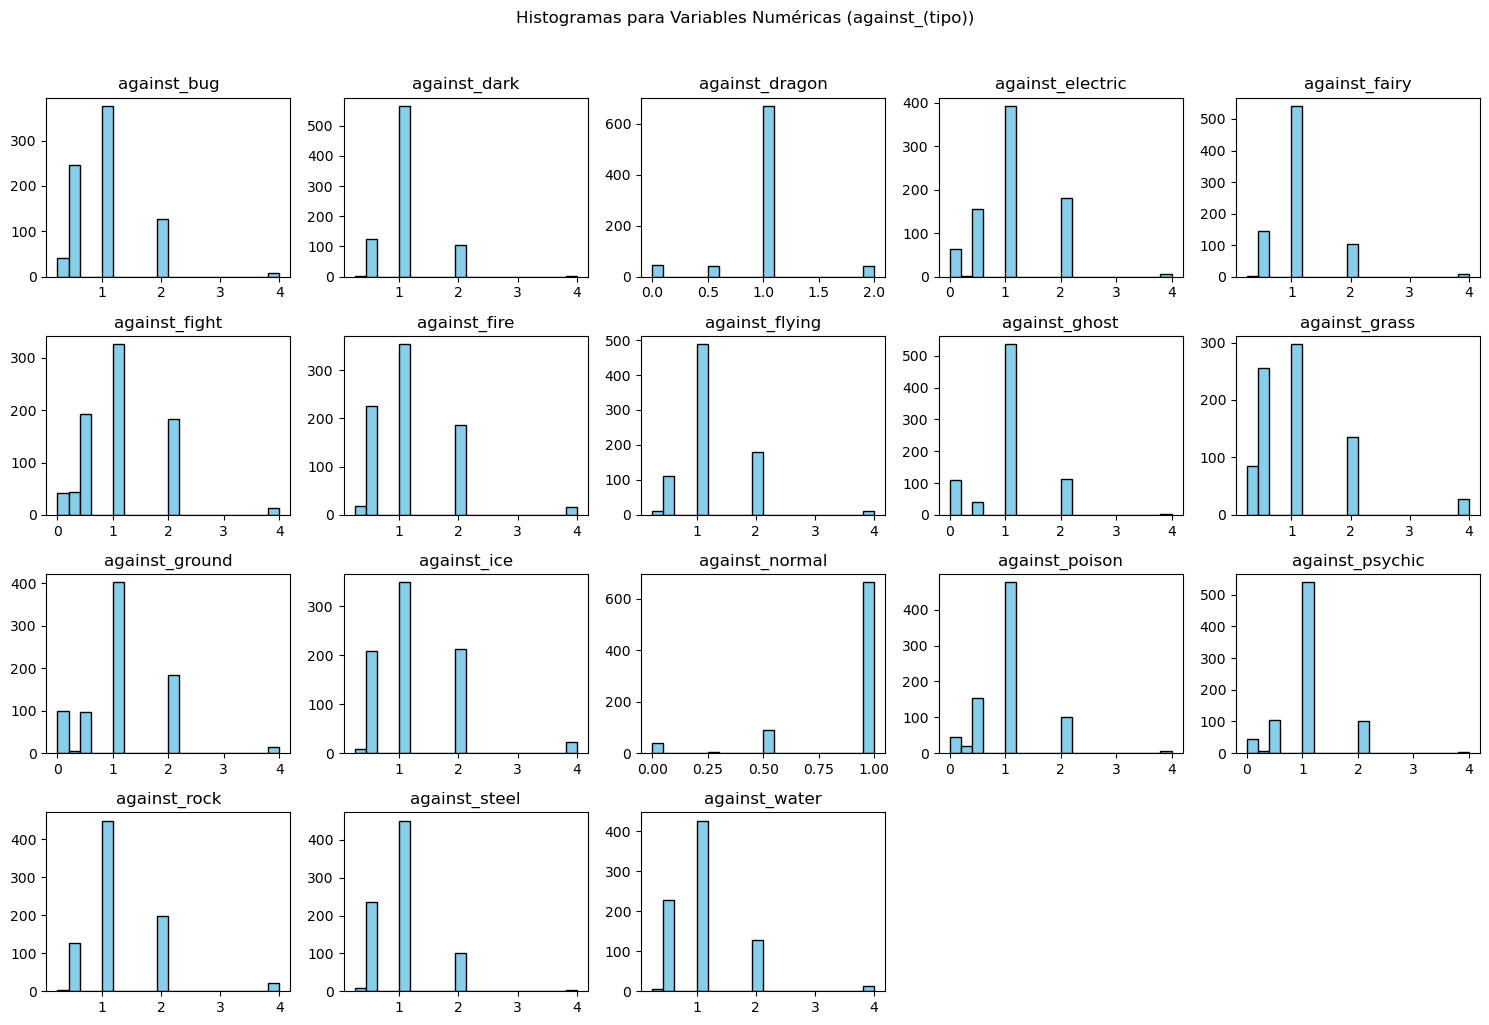

In [131]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols_against):
    plt.subplot(4, 5, i+1)
    plt.hist(df[col], bins=20, color='skyblue', edgecolor='black')
    plt.title(col)
plt.suptitle('Histogramas para Variables Numéricas (against_(tipo))', y=1.02)
plt.tight_layout()
plt.show()

Hem pogut observar una mica les relacions entre els tipus, les més semblants són les relacions entre against_dark i against_ghost. Es pot veure tant al heatmap amb un valor de 0.67 de correlació i si  mirem les taules veiem que són bastant semblants. Tot i així, he decidit deixar-ho igual en comptes de juntar-ho. Hem de tenir en compte que hi ha tipus i subtipus de Pokémon i això pot causar diferències, per tant tot i que siguin semblants preferiexo no unir-los i deixar-los per separat.

### Columnes d'estadistiques

Aquestes columnes siguin segurament les més importants a l'hora de decidir si un Pokémon hauría de ser Legendari, per tant s'ha de tractar amb cura i bé.

In [132]:
stat_cols = ['attack','defense','hp','sp_attack','sp_defense','speed','base_total']

In [133]:
# Crea un conjunto de subgráficos
fig = make_subplots(rows=len(stat_cols), cols=1, subplot_titles=stat_cols)

for i, col in enumerate(stat_cols):
    # Añade un histograma para cada estadística
    fig.add_trace(go.Histogram(x=df[col], name=col), row=i+1, col=1)


# Actualiza el diseño de la figura
fig.update_layout(width=800, height=800, template='plotly_white')
fig.update_yaxes(range=[0, 100])
# Muestra la figura
fig.show()

Farem una cerca dels Outliers:

In [134]:
# Selecciona las columnas de estadísticas de Pokémon
stat_cols = ['attack', 'defense', 'hp', 'sp_attack', 'sp_defense', 'speed', 'base_total']

# Crea un conjunto de subgráficos
fig = make_subplots(rows=len(stat_cols), cols=1, subplot_titles=stat_cols)

for i, col in enumerate(stat_cols):
    # Añade un histograma para cada estadística
    fig.add_trace(go.Histogram(x=df[col], name=col), row=i+1, col=1)

 # Añade un boxplot para cada estadística con outliers positivos resaltados
    fig.add_trace(go.Box(x=df[col], name=col, boxpoints='outliers', orientation='h', marker=dict(color='red')), row=i+1, col=1)


# Actualiza el diseño de la figura
fig.update_layout(width=800, height=1200, template='plotly_white')

# Muestra la figura
fig.show()

Els punts destacats són els outliers que destaquen a les estadístiques. Com sol ser definit, un Pokémon legendari sol tenir unes grans estadístiques a almenys a algun estat, o solen tenir més base total. Per això, la  gran majoria d'aquests a les competicions tenen la seva pròpia (Ubers), ja que tenen unes estadístiques molt per sobre. Per tant, aquest Outliers poden indicar Pokémon legendaris, cosa que ens interessa per fer l'estudi.

A continuació, imprimiré per pantalla els 30 pokémon amb més base_total i 10 de cada estadística per poder comprovar si són outliers, o no.

In [135]:
df[["attack", "name","is_legendary"]].sort_values("attack", ascending=False).head(10)

,attack,name,is_legendary
213,185,Heracross,0
797,181,Kartana,1
382,180,Groudon,1
383,180,Rayquaza,1
444,170,Garchomp,0
408,165,Rampardos,0
353,165,Banette,0
474,165,Gallade,0
247,164,Tyranitar,0
288,160,Slaking,0


In [136]:
df[["defense", "name","is_legendary"]].sort_values("defense", ascending=False).head(10)

,defense,name,is_legendary
305,230,Aggron,0
212,230,Shuckle,0
207,230,Steelix,0
376,200,Regirock,1
712,184,Avalugg,0
90,180,Cloyster,0
79,180,Slowbro,0
410,168,Bastiodon,0
94,160,Onix,0
382,160,Groudon,1


In [137]:
df[["hp", "name","is_legendary"]].sort_values("hp", ascending=False).head(10)

,hp,name,is_legendary
241,255,Blissey,0
112,250,Chansey,0
798,223,Guzzlord,1
717,216,Zygarde,1
201,190,Wobbuffet,0
320,170,Wailord,0
593,165,Alomomola,0
142,160,Snorlax,0
486,150,Giratina,1
425,150,Drifblim,0


In [138]:
df[["sp_attack", "name","is_legendary"]].sort_values("sp_attack", ascending=False).head(10)

,sp_attack,name,is_legendary
149,194,Mewtwo,1
381,180,Kyogre,1
383,180,Rayquaza,1
64,175,Alakazam,0
795,173,Xurkitree,1
93,170,Gengar,0
719,170,Hoopa,1
645,170,Kyurem,1
180,165,Ampharos,0
281,165,Gardevoir,0


In [139]:
df[["sp_defense", "name","is_legendary"]].sort_values("sp_defense", ascending=False).head(10)

,sp_defense,name,is_legendary
212,230,Shuckle,0
377,200,Regice,1
381,160,Kyogre,1
670,154,Florges,0
249,154,Ho-Oh,1
248,154,Lugia,1
475,150,Probopass,0
705,150,Goodra,0
378,150,Registeel,1
379,150,Latias,1


In [140]:
df[["speed", "name","is_legendary"]].sort_values("speed", ascending=False).head(10)

,speed,name,is_legendary
385,180,Deoxys,1
290,160,Ninjask,0
794,151,Pheromosa,1
100,150,Electrode,0
141,150,Aerodactyl,0
64,150,Alakazam,0
616,145,Accelgor,0
253,145,Sceptile,0
14,145,Beedrill,0
149,140,Mewtwo,1


In [141]:
df[["base_total", "name","is_legendary"]].sort_values("base_total", ascending=False).head(30)

,base_total,name,is_legendary
149,780,Mewtwo,1
383,780,Rayquaza,1
382,770,Groudon,1
381,770,Kyogre,1
492,720,Arceus,1
717,708,Zygarde,1
380,700,Latios,1
372,700,Salamence,0
247,700,Tyranitar,0
444,700,Garchomp,0


Podem observar, que la majoria  de Pokémon que destaquen a una característica no són legendaris, però els que destaquen en base_total si ho són, ja que 23 dels 30 són legendaris. Per tant, hem de tenir en compte que els outliers positius no són sempre legendaris en les estadístiques individuals, però si en les generals.

### Altres columnes numèriques

In [142]:
print("Other numerical columns: ",list(set(col_num[18:]) - set(stat_cols)))

Other numerical columns:  ['percentage_male', 'experience_growth', 'is_legendary', 'base_happiness', 'base_egg_steps', 'height_m', 'capture_rate', 'generation', 'weight_kg']


Farem el mateix que als altres apartats, anirem columna per columna i escollirem les necessàries per poder aplicar bé els algorismes d'aprenentatge.

#### Percentage Male

Primer de tot, anem a veure com són les dades d'aquesta columna per fer-nos una idea.

In [143]:
print(df['percentage_male'])

0      88.1
1      88.1
2      88.1
3      88.1
4      88.1
       ... 
796     NaN
797     NaN
798     NaN
799     NaN
800     NaN
Name: percentage_male, Length: 801, dtype: float64


Sembla que tenim el percentatge de que un determinat Pokémon sigui Mascle i també tenim NaNs, què signifiquen les NaNs?

In [144]:
df[df["pokedex_number"] == 801][["name", "is_legendary", "percentage_male"]]

,name,is_legendary,percentage_male
800,Magearna,1,NaN


Les NaNs sembla que són als Pokémon que no tenen gènere. Aquests Pokémon, podem saber de forma general que solen ser legendaris però també hi ha altres Pokémon (Porygon) que no en tenen. Anem a fer una comparació de gènere entre el nombre de Pokèmons legendaris amb i sense gènere amb els normals.

In [145]:
no_genre = df[df.percentage_male.isnull()][["name", "is_legendary"]]
no_genre.is_legendary.value_counts()

is_legendary
1    63
0    35
Name: count, dtype: int64

Dels Pokémon sense gènere, tenim 63 legendaris i 35 no legendaris. Podem fer una comparació sobre quants Pokémon legendari  tenen gènere i quants no? Aixó podrem saber si és una mostra significativa o no.

In [146]:
legendari = df[df.is_legendary == 1][["name","percentage_male"]]
legendari.count()

name               70
percentage_male     7
dtype: int64

De 70 legendaris, tenim 7 amb gènere, anem a veure quins són:

In [147]:
legendari[~legendari.percentage_male.isnull()]

,name,percentage_male
379,Latias,0.0
380,Latios,100.0
484,Heatran,50.0
487,Cresselia,0.0
640,Tornadus,100.0
641,Thundurus,100.0
644,Landorus,100.0


D'aquí podem extreure el següent:

    -Latias sempre és de gènere femení i Latios Masculí, té senti ja que són dos Pokémon complementaris i que es basen en aquesta ideia.
    - Heatran no  entenc per què té un 50% de ser d'un dels gèneres, ja que és un Pokémon que no pot criar igualment.
    - Cresselia és sempre femení, també té sentit ja que és un tret que ens donen a conèixer als jocs..
    - Tornadus, Thundurus i Landorus: Aquest cas, tampoc sabría per què sempre són mascles, segurament sigui per mantenir la estètica que tenen els Pokémon i tenir una cohesió. Tot i que sería el mateix que si no tinguessin gènere.

Finalment, és necessària aquesta columna? Sincerament jo crec que no. Com podem donar-li un valor a les NaNs dels gèneres, no podem posar 0 perquè seria sempre femení, al ser un percentatge de ser mascle. Podria mapejar-les i fer com gènere però tampoc tindria sentit. El millor en aquest cas és no utilitzar la columna, ja que de 70 legendaris, 63 no tenen gènere i són valors bastant únics, millor descartar-los

In [148]:
col_num.remove("percentage_male")

#### Experience Growth

In [149]:
df[["experience_growth"]]

,experience_growth
0,1059860
1,1059860
2,1059860
3,1059860
4,1059860
...,...
796,1250000
797,1250000
798,1250000
799,1250000


In [150]:
# Crear una nueva columna para distinguir entre legendarios y no legendarios
df['legendary_category'] = df['is_legendary'].apply(lambda x: 'Legendary' if x == 1 else 'Non-Legendary')

# Crear el gráfico de dispersión
fig = px.scatter(df, x='experience_growth', color='legendary_category', hover_data=['name'],
                 title='Distribución de Crecimiento de Experiencia',
                 labels={'experience_growth': 'Crecimiento de Experiencia'},
                 category_orders={'legendary_category': ['Non-Legendary', 'Legendary']},
                 width=800, height=500)

# Mostrar el gráfico
fig.show()

Tots els Pokémon legendaris tenen el mateix creixement d'experiència menys 3 (Mew, Celebi i Shaymin). Millor descartar-ho ja que són valors molt únics i pot empitjorar l'entrenament.

In [154]:
col_num.remove("experience_growth")

####  Base Happiness

Base_happiness representa la felicitat base que tindrà un Pokémon, és un paràmetre interessant ja que podrem veure la distribució d'aquesta, però segurament hauré de treure la columna ja que exceptuant alguns Pokémon que evolucionen per felicitat i  altres, molts tindran un valor igual.

In [151]:
df[["base_happiness"]]

,base_happiness
0,70
1,70
2,70
3,70
4,70
...,...
796,0
797,0
798,0
799,0


In [152]:
# Crear el gráfico de dispersión
fig = px.scatter(df, x='base_happiness', y=df.index, color='legendary_category', 
                 symbol='legendary_category', 
                 hover_data=['name'],
                 title='Distribución de Base Happiness',
                 labels={'base_happiness': 'Base Happiness'},
                 category_orders={'legendary_category': ['Non-Legendary', 'Legendary']},
                 width=800, height=500)

# Mostrar el gráfico
fig.show()

In [153]:
# Contar Pokémon no legendarios con base_happiness igual a 70
no_legendarios_70 = df[(df['is_legendary'] == 0) & (df['base_happiness'] == 70)].shape[0]

# Contar Pokémon legendarios con base_happiness igual a 0
legendarios_0 = df[(df['is_legendary'] == 1) & (df['base_happiness'] == 0)].shape[0]

# Mostrar el resultado
print("No Legendarios con base_happiness=70:", no_legendarios_70)
print("Legendarios con base_happiness=0:", legendarios_0)

No Legendarios con base_happiness=70: 661
Legendarios con base_happiness=0: 33


Observem que no hi ha gaire variança entre les dades, ja que hi ha molts No-legendaris amb base 70 i la meitat dels legendaris la tenen a 0. Per tant, millor eliminar aquesta columna

In [155]:
col_num.remove("base_happiness")